# 정리
## 1. 필요한 모듈 가져오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## 2. 데이터를 읽어오기

In [3]:
train_df = pd.read_csv(r'C:\Users\USER\OneDrive\Desktop\2025 수업\DA양성과정 ML\train.csv')
test_df = pd.read_csv(r'C:\Users\USER\OneDrive\Desktop\2025 수업\DA양성과정 ML\test.csv')

## 3. EDA
- Feature랑 Target이 무엇인가
- Target => 커테고리 : 분류, 연속된 숫자 : 회귀
- Feature : 카테고리? 연속된 숫자? 데이터가 아닌가?
- 기계적으로 시각화

In [8]:
train_df.sample(3)
# target => 'count', 연속된 숫자 : 회귀
# 카테고리 : 'season', 'holiday', 'workingday', 'weather'
# 연속된 숫자 :  'temp','atemp', 'humidity', 'windspeed'
# 아직 데이터가 아닌 것 : 'datetime'
train_df.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'count'],
      dtype='object')

## 4. 결측 데이터 처리 

In [10]:
train_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [11]:
test_df.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
dtype: int64

## 5. Feature Engineering
- 데이터가 아닌 것을 데이터로 추출
- 스케일링 => standard scailing
- 인코딩 => onehot encoding

In [21]:
# 데이터가 아닌 것을 데이터로 추출
train_df['year'] = pd.to_datetime( train_df['datetime'] ).dt.year
train_df['hour'] = pd.to_datetime( train_df['datetime'] ).dt.hour
train_df['sin_hour'] = np.sin( (train_df['hour'] / 24) * 2 * np.pi )
train_df['cos_hour'] = np.cos( (train_df['hour'] / 24) * 2 * np.pi )

In [22]:
test_df['year'] = pd.to_datetime( test_df['datetime'] ).dt.year
test_df['hour'] = pd.to_datetime( test_df['datetime'] ).dt.hour
test_df['sin_hour'] = np.sin( (test_df['hour'] / 24) * 2 * np.pi )
test_df['cos_hour'] = np.cos( (test_df['hour'] / 24) * 2 * np.pi )

In [30]:
# 스케일링
# train 데이터로 훈련 => 적용은 train, test 둘다 같이
number_feature = ['temp', 'humidity', 'windspeed', 'sin_hour', 'cos_hour']
sc = StandardScaler( )
sc.fit( train_df[number_feature] )
X = pd.DataFrame( sc.transform( train_df[number_feature]), columns=number_feature )
test_X = pd.DataFrame( sc.transform( test_df[number_feature]), columns=number_feature )

In [38]:
# 인코딩
cate_feature = ['season', 'holiday', 'workingday', 'weather',  'year']
onehot = OneHotEncoder( drop='first', sparse_output=False  )
onehot.fit( train_df[cate_feature] )
X[ onehot.get_feature_names_out() ] = onehot.transform(  train_df[cate_feature] )
test_X[ onehot.get_feature_names_out() ] = onehot.transform(  test_df[cate_feature] )

## 6. 모델 사용
- 하이퍼 파라미터를 gridsearch를 이용해서 찾음
- 훈련
- 검증
- 예측

### 6.1 Linear Regression 

In [40]:
from sklearn.linear_model import LinearRegression

In [41]:
train_x, valid_x, train_y, valid_y = train_test_split( X,
                                                      train_df['count'],
                                                      test_size=0.3,
                                                      random_state=1 )

In [43]:
from sklearn.metrics import mean_squared_error

In [45]:
lr = LinearRegression()
lr.fit(train_x, train_y)
mean_squared_error( valid_y, lr.predict(valid_x) ) ** 0.5

135.17084037779637

In [ ]:
lr_result = test_df[['datetime']].copy()
lr_result['count'] = lr.predict(test_X)
lr_result.to_csv(r'파일경로\파일명.csv', index=False)

### 6.2 KNN

In [58]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_log_error

In [56]:
params = {'n_neighbors':[ 3, 5, 7, 10 ]}
grid_knn = GridSearchCV( KNeighborsRegressor(), params, cv=5,
                       scoring='neg_mean_squared_log_error')
grid_knn.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': [3, 5, 7, 10]},
             scoring='neg_mean_squared_log_error')

In [57]:
grid_knn.cv_results_['mean_test_score']

array([-0.34861764, -0.37149   , -0.38935133, -0.42213103])

In [59]:
mean_squared_log_error( valid_y, grid_knn.predict(valid_x) ) 

0.30106280523678897

In [60]:
knn_result = test_df[['datetime']].copy()
knn_result['count'] = grid_knn.predict(test_X)
knn_result.to_csv(r'파일경로\파일명.csv', index=False)

array([335.        ,  78.33333333,  26.        , ..., 402.66666667,
        84.        , 280.        ])

### 6.3 RandomForest

In [61]:
from sklearn.ensemble import RandomForestRegressor

In [70]:
params = {'max_depth': [20, 23, 26, 30],
            'min_samples_leaf' : [1]}

grid_rf = GridSearchCV( RandomForestRegressor(random_state=777), params, cv=5,
                       scoring='neg_mean_squared_log_error')
grid_rf.fit(train_x, train_y)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=777),
             param_grid={'max_depth': [20, 23, 26, 30],
                         'min_samples_leaf': [1]},
             scoring='neg_mean_squared_log_error')

In [71]:
result = pd.DataFrame( grid_rf.cv_results_['params'] )
result['score'] =  grid_rf.cv_results_['mean_test_score'] 
pd.pivot_table(result, columns='max_depth', index='min_samples_leaf')

score                              
max_depth               20        23        26        30
min_samples_leaf                                        
1                -0.155264 -0.155202 -0.155474 -0.155378

### 6.4 multi output ML
- ML에서 target은 무조건 1 => 1차원
- 같은 feature를 가지고 n개의 target을 예측하고 싶다
- n개의 모델을 만들어야 함...

In [78]:
from sklearn.multioutput import MultiOutputRegressor

In [ ]:
train_x_m, valid_x_m, train_y_m, valid_y_m = train_test_split(X,
                                                              train_df[['casual', 'registered', 'count']],
                                                              test_size=0.3,
                                                              random_state=1)

In [ ]:
multi_rf = MultiOutputRegressor( RandomForestRegressor( max_depth=23 ) )
multi_rf.fit( train_x_m,  train_y_m[['casual', 'registered']])

In [94]:
mean_squared_log_error( valid_y_m['count'], multi_rf.predict( valid_x_m ).sum(axis=1) ) ** 0.5

0.3766571957030903

In [96]:
result_m_rf = test_df[['datetime']]
result_m_rf['count'] = multi_rf.predict(test_X).sum(axis=1)
result_m_rf.to_csv(r'', index=False)

array([288.28416667,  73.19      ,  30.04      , ..., 303.79      ,
        64.56      , 318.04      ])

# 훈련된 모델 저장하기
- pickle

In [98]:
import joblib

In [99]:
joblib.dump( grid_rf, r'C:\Users\USER\OneDrive\Desktop\2025 수업\DA양성과정 ML\test.pkl' )

['C:\\Users\\USER\\OneDrive\\Desktop\\2025 수업\\DA양성과정 ML\\test.pkl']

In [ ]:
joblib.load( r'C:\Users\USER\OneDrive\Desktop\2025 수업\DA양성과정 ML\test.pkl'  )

# 평가하기
- 분류 => 정확도(accuracy)
    - target 데이터가 불균형할 때 적적할지 않을 수 가 있음...
- 회귀 => 오차(실제 데이터와 예측값 사이의 "거리")

In [ ]:
95 - 양품     암에 안걸림
5  - 불량품   암에 걸림
무조건 양품이라고 예측!? 95%

In [ ]:
분류 => 양성, 음성
우리가 관심있는 것이 양성 => 1, 불량품
그게 아닌게 음성 => 0 , 양품

In [ ]:
재현율(recall)
양성이라고 예측한 비율
양성 중에
=> 높이면 => "도전적인" 모델이 만들어짐(도전 해볼만 하면 다 양성이라고 함)
=> 불량품이 아닌것도 불량품이라고하여 코스트가 올라감

In [ ]:
정밀도
양성을 제대로 예측한 비율
양성이라고 예측한 것 중
=> 높이면 => 무리한 도전을 안함(정말 확실한 양성만 양성이라고 함)
=> 비중이 적은 양성 데이터를 대부분 놓침

In [106]:
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
# 1. 하이퍼 파라미터를 정확도를 기준으로 찾는게 아니라 재현율이나 f1-score기준으로 검색
# 2. 기준 확률을 바꿈
# 3. rf

In [122]:
titanic = sns.load_dataset('titanic').dropna(subset=['age'])
X = titanic[['age', 'fare']]
y = titanic['survived']
kn = KNeighborsClassifier()
kn.fit(X, y)
fi_list = []
for i in range(20, 51):
    temp_y = (kn.predict_proba(X)[:, 1:] > i/100).astype(int)
    f1 = f1_score( y, temp_y )
    fi_list.append(f1)

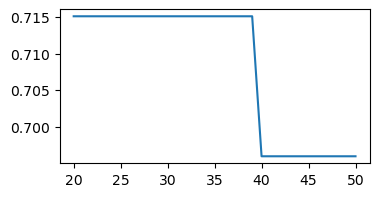

In [124]:
plt.figure(figsize=(4, 2))
plt.plot( range(20, 51), fi_list   )
plt.show()

In [125]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
RandomForestClassifier(class_weight={'w1':0.7, 'w2':0.3})

# 비지도학습
- target 데이터가 없다!!
- 거리나 변동성 등을 활용해서 데이터에 내재된 패턴을 스스로 찾아줌
- 사람은 결과를 보고 의미를 해석, 부여 함
- 군집분석
- 차원축소

In [ ]:
# 군집분석 : k-means clustering

In [126]:
from sklearn.cluster import KMeans

In [128]:
iris_df = sns.load_dataset('iris')

In [132]:
# 비지도 학습 모델
# 모델 생성
# 훈련
# 예측, 변형
kmeans = KMeans(n_clusters=3)
kmeans.fit(iris_df.iloc[:, :-1] )

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=3)

In [ ]:
iris_df['kmean_cluster'] = kmeans.predict( iris_df.iloc[:, :-1]  )

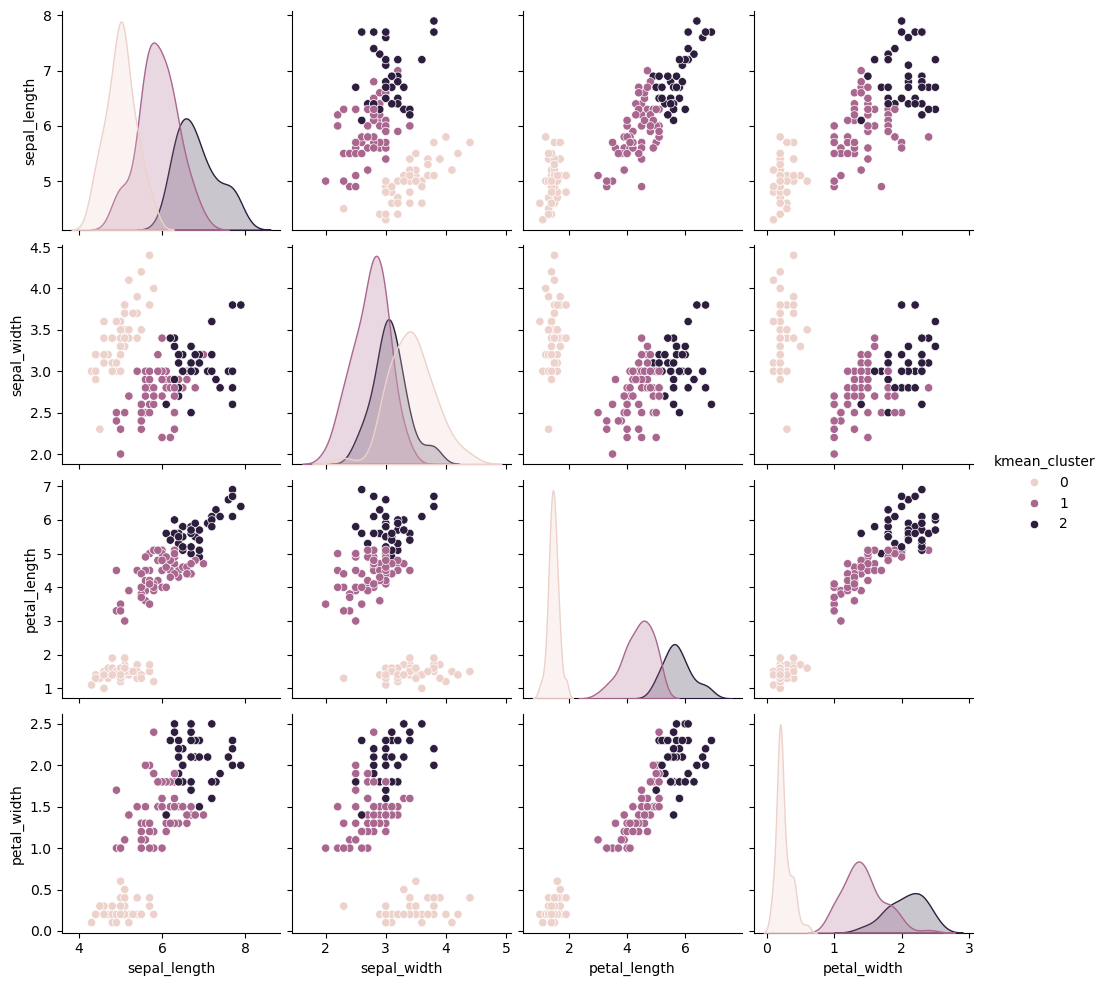

In [140]:
sns.pairplot(iris_df, hue='kmean_cluster')
plt.show()

In [ ]:
wcss_list = []
for k in range(1, 16):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(iris_df.iloc[:, :4])
    wcss = kmeans.inertia_
    wcss_list.append(wcss)

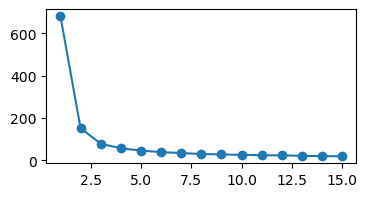

In [148]:
plt.figure(figsize=(4, 2))
plt.plot(range(1, 16), wcss_list, marker='o')
plt.show()

In [ ]:
customer_df = pd.read_csv(r'C:\Users\USER\OneDrive\Desktop\2025 수업\DA양성과정 ML\고객설문.csv')
# 스케일링
sc = StandardScaler()
customer_df[ ['Satisfaction', 'Loyalty'] ] = sc.fit_transform(customer_df)
# K를 찾고
wcss_list = []
for k in range(1, 16):
    km = KMeans(k)
    km.fit(customer_df)
    wcss = km.inertia_
    wcss_list.append(wcss)
# 군집을 나누어서 그림 그리고 해석하기

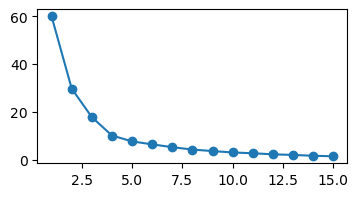

In [155]:
plt.figure(figsize=(4, 2))
plt.plot(range(1, 16), wcss_list, marker='o')
plt.show()

In [ ]:
km = KMeans(3)
km.fit(customer_df)
customer_df['3_label'] = km.predict(customer_df)

km = KMeans(4)
km.fit(customer_df.iloc[:, :2])
customer_df['4_label'] = km.predict(customer_df.iloc[:, :2])

km = KMeans(5)
km.fit(customer_df.iloc[:, :2])
customer_df['5_label'] = km.predict(customer_df.iloc[:, :2])

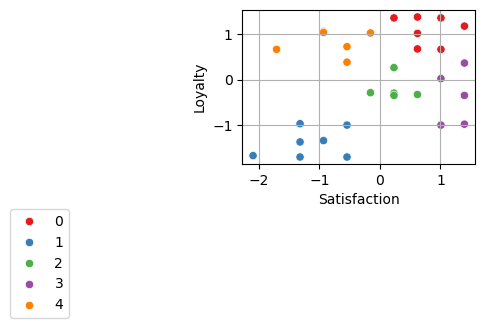

In [167]:
plt.figure(figsize=(3, 2))
sns.scatterplot( customer_df, x='Satisfaction', y='Loyalty', hue='5_label',
               palette='Set1')
plt.legend(loc=(-1, -1))
plt.grid()
plt.show()

In [169]:
# PCA, 주성분 분석
# 기존 데이터에서 가장 변동성이 큰 축부터 가져와서
# 기존 데이터 정보의 95%를 보존하고 차원의 수를 줄임

In [171]:
from sklearn.decomposition import PCA

In [177]:
pca = PCA()
pca.fit( iris_df.iloc[:, :4] )
np.cumsum( pca.explained_variance_ratio_ )

array([0.92461872, 0.97768521, 0.99478782, 1.        ])

In [180]:
pca = PCA(n_components=2)
X = pca.fit_transform( iris_df.iloc[:, :4] )
y = iris_df['species']
train_x, valid_x, train_y, valid_y = train_test_split(X, y,
                                                      test_size=0.2,
                                                      random_state=1,
                                                      stratify=y)

In [181]:
knn = KNeighborsClassifier()
knn.fit(train_x, train_y)
knn.score(valid_x, valid_y)

0.9666666666666667

In [183]:
pca = PCA(n_components=0.95)
pca.fit_transform( iris_df.iloc[:, :4] )

array([[-2.68412563,  0.31939725],
       [-2.71414169, -0.17700123],
       [-2.88899057, -0.14494943],
       [-2.74534286, -0.31829898],
       [-2.72871654,  0.32675451],
       [-2.28085963,  0.74133045],
       [-2.82053775, -0.08946138],
       [-2.62614497,  0.16338496],
       [-2.88638273, -0.57831175],
       [-2.6727558 , -0.11377425],
       [-2.50694709,  0.6450689 ],
       [-2.61275523,  0.01472994],
       [-2.78610927, -0.235112  ],
       [-3.22380374, -0.51139459],
       [-2.64475039,  1.17876464],
       [-2.38603903,  1.33806233],
       [-2.62352788,  0.81067951],
       [-2.64829671,  0.31184914],
       [-2.19982032,  0.87283904],
       [-2.5879864 ,  0.51356031],
       [-2.31025622,  0.39134594],
       [-2.54370523,  0.43299606],
       [-3.21593942,  0.13346807],
       [-2.30273318,  0.09870885],
       [-2.35575405, -0.03728186],
       [-2.50666891, -0.14601688],
       [-2.46882007,  0.13095149],
       [-2.56231991,  0.36771886],
       [-2.63953472,

In [ ]:
pandas(dataframe)
시각화
feature engineering
    데이터가 아닌것 => 데이터
    스케일링
    인코딩
분류
회귀
비지도 학습